In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import csv
plt.style.use('fivethirtyeight')

In [3]:
# importing the data
df = yf.download("INFY.NS", start="2020-07-01", end="2021-06-30")

[*********************100%***********************]  1 of 1 completed


In [4]:
df['Date'] = df.index
df= df.set_index(pd.DatetimeIndex(df['Date'].values))
df

,Open,High,Low,Close,Adj Close,Volume,Date
2020-07-01,737.250000,742.299988,729.750000,731.900024,702.655945,5477468,2020-07-01
2020-07-02,737.349976,765.450012,735.400024,756.599976,726.368958,17263756,2020-07-02
2020-07-03,755.000000,764.000000,752.500000,762.700012,732.225281,7796572,2020-07-03
2020-07-06,765.200012,775.000000,761.500000,764.000000,733.473267,8810958,2020-07-06
2020-07-07,769.400024,796.950012,765.549988,794.150024,762.418640,19362533,2020-07-07
...,...,...,...,...,...,...,...
2021-06-23,1525.000000,1525.000000,1498.650024,1503.150024,1474.331787,5529809,2021-06-23
2021-06-24,1517.000000,1568.750000,1511.199951,1559.199951,1529.307007,10785137,2021-06-24
2021-06-25,1572.000000,1578.000000,1543.000000,1574.199951,1544.019531,9780240,2021-06-25
2021-06-28,1572.900024,1580.150024,1560.599976,1571.800049,1541.665649,5019178,2021-06-28


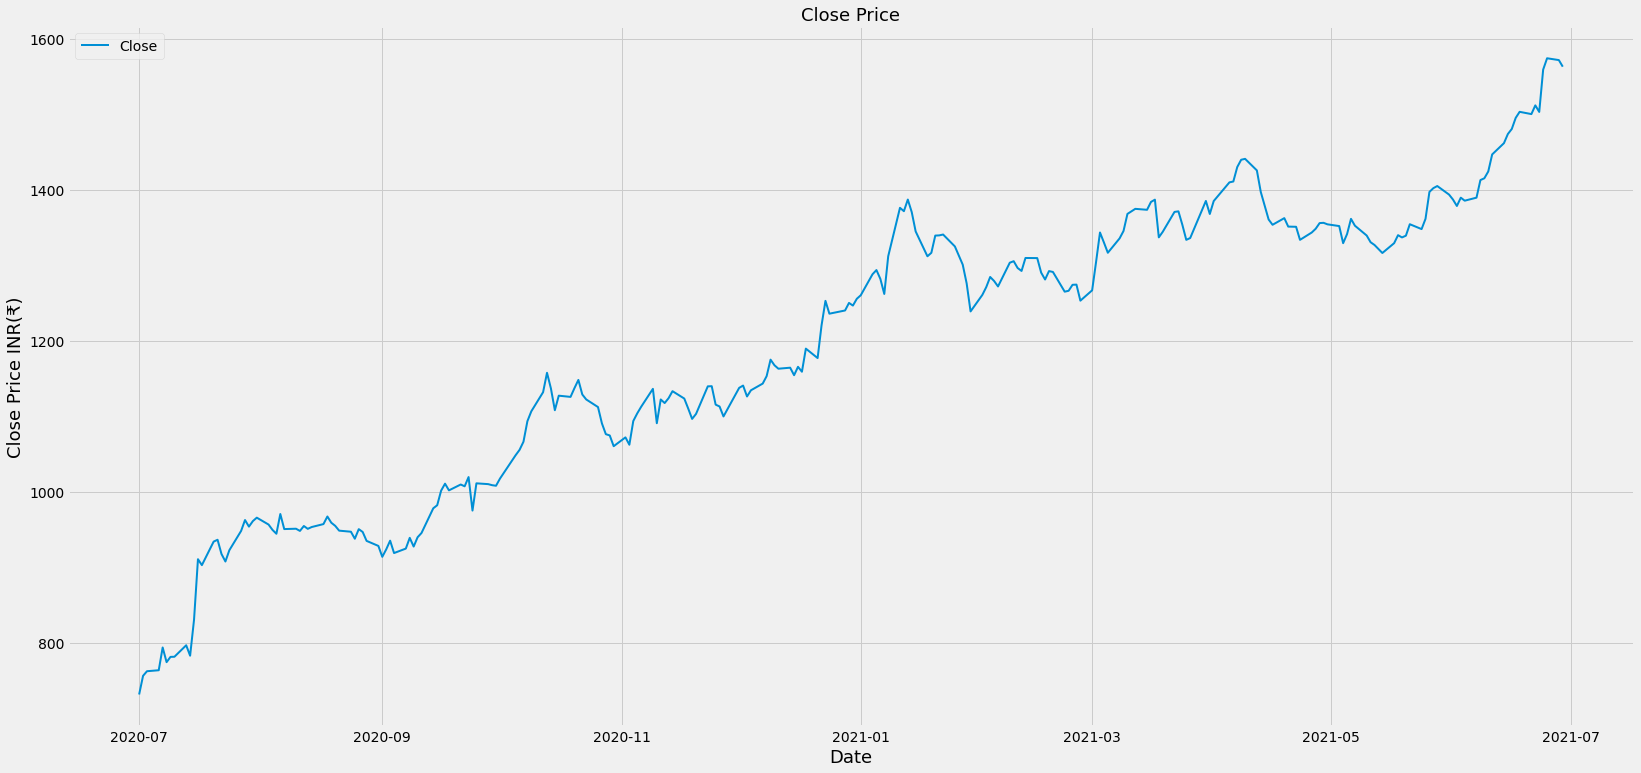

In [5]:
# Visualizing the data
plt.figure(figsize=(25,12))
plt.title('Close Price', fontsize=18)
plt.plot(df['Close'], label= 'Close',linewidth=2.0)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR(₹)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

# Combination of Two Moving Averages and Bollinger Bands

### Two Moving Averages

In [6]:
# Creating new dataset
data = pd.DataFrame()
data['Date'] = df['Date']
data['Close'] = df['Close']
data['ShortMA'] = df['Close'].rolling(window=21).mean()
data['LongMA'] = df['Close'].rolling(window=55).mean()

### Bolinger Bands

In [7]:
# Creating new dataset
data2 = pd.DataFrame()
data2['Close'] = df['Close']
# Let the time period be 21
period = 21
# Calculate Simple Moving Average
data2['SMA'] = df['Close'].rolling(window=period).mean()
# Calculate Standard Deviation
data2['Std'] = df['Close'].rolling(window=period).std()
# Calculate the Upper Bollinger Band
data2['Upper'] = data2['SMA'] + 2*data2['Std']
# Calculate the Lower Bollinger Band
data2['Lower'] = data2['SMA'] - 2*data2['Std']

### Combining SMA and Bollinger Bands

In [8]:
# Creating the final data frame
dframe = pd.DataFrame()
dframe['Date'] = df['Date']
dframe['Close'] = df['Close']
dframe['ShortMA'] = data['ShortMA']
dframe['LongMA'] = data['LongMA']
dframe['SMA'] = data2['SMA']
dframe['Upper'] = data2['Upper']
dframe['Lower'] = data2['Lower']

# Buy sell signal generator function
def buy_sell_signal(data):

    buy_signal = []
    sell_signal = []
    position = []

    for i in range (len(data)):

        if data['Close'][i] < data['Lower'][i] and data['ShortMA'][i] < data['LongMA'][i]: #then buy
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)
            position.append(0)
        elif data['Close'][i] > data['Upper'][i] and data['ShortMA'][i] > data['LongMA'][i]: #then sell
            sell_signal.append(data['Close'][i])
            buy_signal.append(np.nan)
            position.append(1)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            position.append(-1)

    return(buy_signal,sell_signal,position)

buy_sell = buy_sell_signal(dframe)
dframe['Buy_Signal'] = buy_sell[0]
dframe['Sell_Signal'] = buy_sell[1]
dframe['Position'] = buy_sell[2]


In [9]:
# Writing the buy sell signals in a file
f = open('Testing1.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Position', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (len(dframe)):
    if dframe['Position'][i] != -1:
        row= [dframe['Date'][i], dframe['Buy_Signal'][i], dframe['Sell_Signal'][i], dframe['Position'][i]]
        writer.writerow(row)
f.close()

### Position Management

In [10]:
# Given that initial capital = 100000
init_capital = 100000
capital = init_capital
# importing the buy sell signals
sigData= pd.read_csv(r'Testing1.csv')
sigData= sigData.set_index(pd.DatetimeIndex(sigData['Date'].values))

In [11]:
#logic
stocks = 0
stop_loss = capital * 95/100
position = 0
buy_signal = 0
buy_trans = 0
sell_signal = 0
sell_trans = 0

for i in range (len(sigData)):
    if not np.isnan(sigData['Buy'][i]):
        buy_signal = buy_signal + 1

        if sigData['Position'][i] == position:
            buy_trans = buy_trans + 1
            stocks = (int)(capital/sigData['Buy'][i] * 99/100)
            sigData['Stocks Bought'][i] = stocks
            position = 1

    elif not np.isnan(sigData['Sell'][i]):
        sell_signal = sell_signal + 1

        if sigData['Position'][i] == position:
            sell_trans = sell_trans + 1
            capital = stocks * sigData['Sell'][i] * 99/100
            # putting stop loss
            if capital < stop_loss:
                continue
            sigData['Sell Price'][i] = capital
            position = 0
            returnPercent = (capital - init_capital)/init_capital * 100
            sigData['Return%'][i] = returnPercent

if position == 1:
    capital = stocks * df['Close'][-1] * 99/100
    sigData['Sell Price'][i-1] = capital
    returnPercent = (capital - init_capital)/init_capital * 100
    sigData['Return%'][i-1] = returnPercent
    sell_trans = sell_trans + 1

In [12]:
# Write in Output file

f = open('Testing1.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (0, len(sigData)):
    if ((not np.isnan(sigData['Buy'][i])) or (not np.isnan(sigData['Sell'][i]))) and ((not np.isnan(sigData['Stocks Bought'][i])) or (not np.isnan(sigData['Sell Price'][i]))):
        row= [sigData['Date'][i], sigData['Buy'][i], sigData['Sell'][i], sigData['Stocks Bought'][i], sigData['Sell Price'][i], sigData['Return%'][i]]
        writer.writerow(row)
f.close()

In [13]:
stockData= pd.read_csv(r'Training1.csv')
stockData= stockData.set_index(pd.DatetimeIndex(stockData['Date'].values))

# Calculating benchmark return
benchmark = capital * data['Close'][-1]/data['Close'][0]
benchmarkPercent = (benchmark-capital)/capital * 100

# Calculate final return Percent
returnPercent = stockData['Return%'][-1]
print('Benchmark return = ', benchmarkPercent, '%')
print('Actual Return = ', returnPercent , '%')
# Number of Buy and Sell signals generated
print('Number of Buy Signals = ', buy_signal)
print('Number of Sell signals = ', sell_signal)
# Number of Transactions
print('Number of Buy Transactions = ', buy_trans)
print('Number of Sell transactions = ', sell_trans)

Benchmark return =  113.56059525745425 %
Actual Return =  43.69929434448242 %
Number of Buy Signals =  0
Number of Sell signals =  22
Number of Buy Transactions =  0
Number of Sell transactions =  0


# RSI (Relative Strength Index)

In [32]:
# Prepare the data to calculate RSI
# Get the difference in Price from previous day
delta = df['Close'].diff(1)
delta = delta.dropna()
# Get the Positive Gain and Negative Gain
up = delta.copy()
down = delta.copy()
up[up<0] = 0
down[down > 0] = 0

# Time period
period = 5

# Calculate average gain and loss
avg_gain = up.rolling(window=period).mean()
avg_loss = abs(down.rolling(window=period).mean())

# Calculate the RS
RS = avg_gain/avg_loss
# Calculate the RSI
RSI = 100.0 - (100.0 / (1.0 + RS))

In [33]:
# Creating new Dataframe
dframe = pd.DataFrame()
dframe['Date'] = df['Date']
dframe['Close'] = df['Close']
dframe['RSI'] = RSI

In [34]:
def buy_sell_rsi(data):
    buy_signal = []
    sell_signal = []
    position = []
    for i in range (len(data)-1):
        if data['RSI'][i] > 70 and data['RSI'][i+1] <= 70:
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])
            position.append(1)
        elif data['RSI'][i]<30 and data['RSI'][i+1] >= 30:
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)
            position.append(0)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            position.append(-1)

    buy_signal.append(np.nan)
    sell_signal.append(np.nan)
    position.append(-1)
    return(buy_signal, sell_signal, position)

buy_sell_signal = buy_sell_rsi(dframe)
dframe['Buy_Signal'] = buy_sell_signal[0]
dframe['Sell_Signal'] = buy_sell_signal[1]
dframe['Position'] = buy_sell_signal[2]


In [35]:
# Writing the buy sell signals in a file

f = open('Testing2.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Position', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (len(dframe)):
    if dframe['Position'][i] != -1:
        row= [dframe['Date'][i], dframe['Buy_Signal'][i], dframe['Sell_Signal'][i], dframe['Position'][i]]
        writer.writerow(row)
f.close()

## Position Management

In [36]:
# Given that initial capital = 100000
init_capital = 100000
capital = init_capital
# importing the buy sell signals
sigData= pd.read_csv(r'Testing2.csv')
sigData= sigData.set_index(pd.DatetimeIndex(sigData['Date'].values))

In [37]:
stocks = 0
stop_loss = capital * 95/100
position = 0
buy_signal = 0
buy_trans = 0
sell_signal = 0
sell_trans = 0

for i in range (len(sigData)):
    if not np.isnan(sigData['Buy'][i]):
        buy_signal = buy_signal + 1

        if sigData['Position'][i] == position:
            buy_trans = buy_trans + 1
            stocks = np.int(capital/sigData['Buy'][i] * 99/100)
            sigData['Stocks Bought'][i] = stocks
            position = 1

    elif not np.isnan(sigData['Sell'][i]):
        sell_signal = sell_signal +1

        if sigData['Position'][i] == position:
            sell_trans = sell_trans + 1
            capital = stocks * sigData['Sell'][i] * 99/100
            # putting stop loss
            if capital < stop_loss:
                continue
            sigData['Sell Price'][i] = capital
            position = 0
            returnPercent = (capital - init_capital)/init_capital * 100
            sigData['Return%'][i] = returnPercent



# Selling all stocks at the end if last signal was a buy signal
if position == 1:
    capital = stocks * df['Close'][-1] * 99/100
    sigData['Sell Price'][i-1] = capital
    returnPercent = (capital - init_capital)/init_capital * 100
    sigData['Return%'][i-1] = returnPercent
    sell_trans = sell_trans + 1


C:\Users\reesh\AppData\Local\Temp\ipykernel_9528\1523665152.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stocks = np.int(capital/sigData['Buy'][i] * 99/100)
C:\Users\reesh\AppData\Local\Temp\ipykernel_9528\1523665152.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigData['Stocks Bought'][i] = stocks
C:\Users\reesh\AppData\Local\Temp\ipykernel_9528\1

In [38]:
# Write in Output file

f = open('Testing2.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (0, len(sigData)):
    if ((not np.isnan(sigData['Buy'][i])) or (not np.isnan(sigData['Sell'][i]))) and ((not np.isnan(sigData['Stocks Bought'][i])) or (not np.isnan(sigData['Sell Price'][i]))):
        row= [sigData['Date'][i], sigData['Buy'][i], sigData['Sell'][i], sigData['Stocks Bought'][i], sigData['Sell Price'][i], sigData['Return%'][i]]
        writer.writerow(row)
f.close()

In [39]:
stockData= pd.read_csv(r'Testing2.csv')
stockData= stockData.set_index(pd.DatetimeIndex(stockData['Date'].values))

In [40]:
# Calculating benchmark return
benchmark = capital * df['Close'][-1]/df['Close'][0]
benchmarkPercent = (benchmark-capital)/capital * 100
# Calculate final return Percent
returnPercent = stockData['Return%'][-1]
print('Benchmark return = ', benchmarkPercent, '%')
print('Actual Return = ', returnPercent , '%')
# Number of Buy and Sell signals generated
print('Number of Buy Signals = ', buy_signal)
print('Number of Sell signals = ', sell_signal)
# Number of Transactions
print('Number of Buy Transactions = ', buy_trans)
print('Number of Sell transactions = ', sell_trans)

# Maximum Drawdown

min = df['Close'].min()
max = df['Close'].max()
drawdown = (min - max)/max * 100
print('Maximum Drawdown = ', drawdown)

Benchmark return =  113.56059525745425 %
Actual Return =  34.6255007055664 %
Number of Buy Signals =  16
Number of Sell signals =  23
Number of Buy Transactions =  11
Number of Sell transactions =  11
Maximum Drawdown =  -53.50654001296231
